Source: https://open-meteo.com/en/docs/historical-weather-api#latitude=47.4984&longitude=19.0404&start_date=2023-01-01&end_date=2024-12-04

In [1]:
import pandas as pd
from datetime import date

In [2]:
df = pd.read_csv("open-meteo-past-year.csv")
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
daily_stats = df.groupby('date')['temperature_2m (°C)'].agg(['min', 'max', 'mean'])
df = daily_stats.reset_index()
df = df[df['date'] >= date(2024, 9, 1)]
df = df.reset_index(drop=True)
df

,date,min,max,mean
0,2024-09-01,20.5,32.0,26.054167
1,2024-09-02,18.7,31.5,25.433333
2,2024-09-03,18.9,32.4,25.700000
3,2024-09-04,19.0,32.2,25.308333
4,2024-09-05,19.9,29.2,24.166667
...,...,...,...,...
89,2024-11-29,1.9,8.3,5.291667
90,2024-11-30,1.7,8.3,3.900000
91,2024-12-01,0.2,7.8,2.800000
92,2024-12-02,-1.4,4.5,0.412500


In [3]:
import requests

def service_forecast(start: date, end: date) -> float:
    """Returns predicted mean for the next day."""
    assert start <= end
    response = requests.get(
        f"https://api.open-meteo.com/v1/forecast?latitude=47.4984&longitude=19.0404&daily=temperature_2m_max,temperature_2m_min&start_date={start}&end_date={end}"
    )
    response.raise_for_status()
    data = response.json()
    max_temps = data["daily"]["temperature_2m_max"]
    min_temps = data["daily"]["temperature_2m_min"]
    forecast = [
        round(0.5 * (max_temp + min_temp), 2)
        for max_temp, min_temp in zip(max_temps, min_temps)
    ]
    return forecast

In [4]:
service_forecasts = service_forecast(min(df["date"]), max(df["date"]))

In [5]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('lstm_model.keras')

def lstm(X: list) -> float:
    return round(model(np.array([X])).numpy()[0][0], 2)

c:\Users\MDancso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
sequence_length = 7

lstm_forecasts = list(df["mean"][:sequence_length].values) # Fill up first days with actual values

mean_values = df["mean"]
for i in range(len(mean_values) - sequence_length):
    X = mean_values[i:i + sequence_length].values
    lstm_forecasts.append(lstm(X))

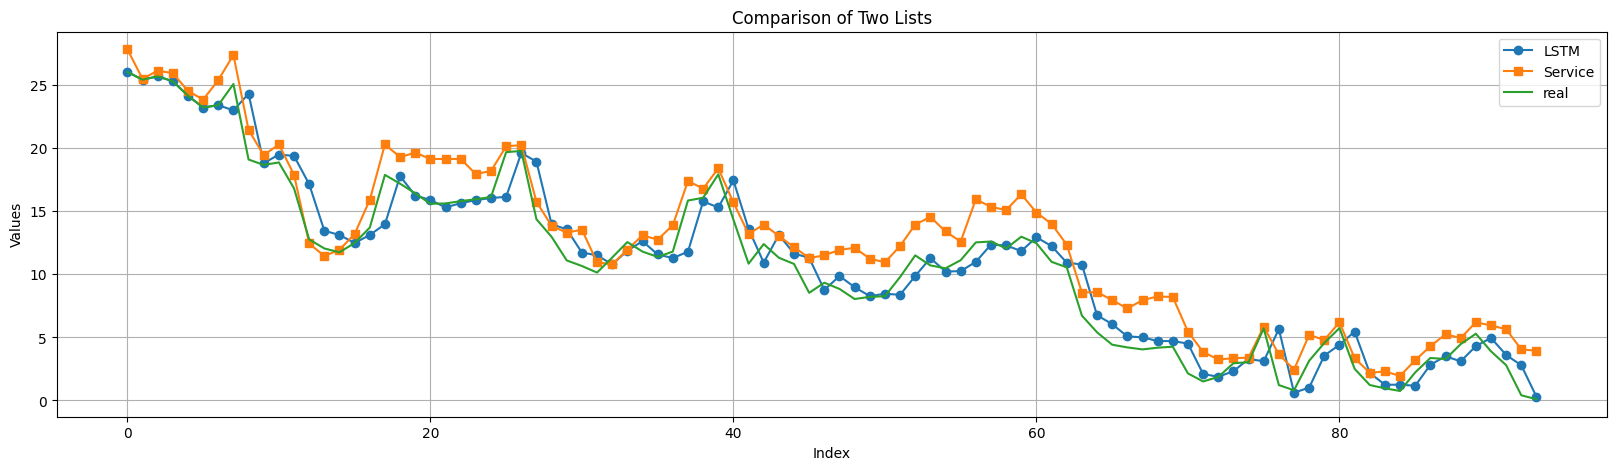

In [7]:
import matplotlib.pyplot as plt

# Create an x-axis based on the length of the lists
x = range(len(lstm_forecasts))

plt.figure(figsize=(20, 5))

# Plot both lists on the same chart
plt.plot(x, lstm_forecasts, label='LSTM', marker='o')
plt.plot(x, service_forecasts, label='Service', marker='s')
plt.plot(x, df["mean"], label="real")

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Two Lists')
plt.legend()

# Show the plot
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

In [8]:
# Calculate the errors for each prediction
errors = df["mean"][sequence_length:] - np.array(lstm_forecasts[sequence_length:])

# Calculate statistics
average_error = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))
min_error = np.min(np.abs(errors))

# Print error statistics
print(f"Validation Error Statistics:")
print(f"Average Error: {average_error:.2f}")
print(f"Maximum Error: {max_error:.2f}")
print(f"Minimum Error: {min_error:.2f}")

Validation Error Statistics:
Average Error: 1.29
Maximum Error: 5.22
Minimum Error: 0.00


In [9]:
# Calculate the errors for each prediction
errors = df["mean"] - np.array(service_forecasts)

# Calculate statistics
average_error = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))
min_error = np.min(np.abs(errors))

# Print error statistics
print(f"Validation Error Statistics:")
print(f"Average Error: {average_error:.2f}")
print(f"Maximum Error: {max_error:.2f}")
print(f"Minimum Error: {min_error:.2f}")

Validation Error Statistics:
Average Error: 1.89
Maximum Error: 4.06
Minimum Error: 0.07


In [10]:
df["lstm"] = lstm_forecasts
df["service"] = service_forecasts
df

,date,min,max,mean,lstm,service
0,2024-09-01,20.5,32.0,26.054167,26.054167,27.85
1,2024-09-02,18.7,31.5,25.433333,25.433333,25.50
2,2024-09-03,18.9,32.4,25.700000,25.700000,26.15
3,2024-09-04,19.0,32.2,25.308333,25.308333,25.95
4,2024-09-05,19.9,29.2,24.166667,24.166667,24.55
...,...,...,...,...,...,...
89,2024-11-29,1.9,8.3,5.291667,4.310000,6.20
90,2024-11-30,1.7,8.3,3.900000,4.960000,5.95
91,2024-12-01,0.2,7.8,2.800000,3.610000,5.65
92,2024-12-02,-1.4,4.5,0.412500,2.790000,4.05


In [11]:
df.to_csv("test.csv", index=False)